# RESEAUX RECURENTS


Les réseaux de neurones récurrents (ou RNN pour Recurrent Neural Networks) sont une catégorie de réseaux de neurones dédiée au traitement de séquences

<img src='images/rnn1.png'>


<img src='images/rnn2.jpg'>

1 - Classification d'image
2 - Description d'images.
3 - Analyse des sentiments.
4 - Traduction
5 - Classification de vidéos

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import re
import string

In [2]:
df = pd.read_csv("datasets/twitter.csv")

In [3]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
## Répartition du dataset
print((df.target == 1).sum()) # Catastrophe
print((df.target == 0).sum()) # Non

3271
4342


## PREPROCESSING

### LES STOPWORDS ET LES CARACTERES INUTILES

En NLP les stopword sont des mots n'ajoutant aucun sens particulier a une phrase. En français on parle de mot vide ( de sens ). Il convient donc de les supprimer

In [5]:
# SI NLTK n'est pas installé pip install NLK
import nltk
# On télécharge les stopwords
nltk.download('stopwords')
# On importe les stopwords
from nltk.corpus import stopwords
# Les données étant en anglais on définit le lanqage des stopwords à utiliser
stop = set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zakar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


En plus de ces mots vides, il existe bon nombre de caractère inutiles pour le NLP comme la ponctuation ou les url ... On va donc créer des fonctions nous permettant de nettoyer nos données.

In [6]:
#Fonction supprimant les stopwords
def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

# Fonction de suppression des url
def text_cleaning(text):
  text = re.sub(r'@[A-Za-z0-9]+', '', text)     # Supp @
  text = re.sub(r'@[A-Za-zA-Z0-9]+', '', text)  # Supp @
  text = re.sub(r'@[A-Za-z]+', '', text)        # Supp @
  text = re.sub(r'@[-)]+', '', text)            # Supp @
  text = re.sub(r'#', '', text )                # Supp #
  text = re.sub(r'RT[\s]+', '', text)           # Supp RT
  text = re.sub(r'https?\/\/\S+', '', text)     # Supp Lien
  text = re.sub(r'&[a-z;]+', '', text)          # Supp '&gt;'

  return text

# Fonction de suppression la ponctuation
def remove_punct(text):
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)

In [7]:
# On supprime les stopwords
df["text"] = df.text.map(remove_stopwords)
# On supprime les URL de nos données
df["text"] = df.text.map(text_cleaning) 
# On supprime la ponctuation
df["text"] = df.text.map(remove_punct)

In [8]:
# Les données néttoyées
df.text

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       13000 people receive wildfires evacuation orde...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ahrary  control wild fires california even nor...
7610    m194 0104 utc5km volcano hawaii httptcozdtoyd8ebj
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

In [9]:
from collections import Counter
# Fonction retournant le nombre de mot unique
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count
counter = counter_word(df.text)

In [10]:
# On stocke le nombre de mot unique on s'en servira plus tard
num_unique_words = len(counter)

### SEPARATION DU DATASET

In [11]:
# On sépare notre dataset en jeu d'entairenement et de validation
from sklearn.model_selection import train_test_split

train_df,val_df = train_test_split(df,test_size=0.2)


# On sépare les données de la cible et on créé des tableaux pour stocker tout ça

train_phrases = train_df.text.to_numpy()
train_labels = train_df.target.to_numpy()
val_phrases = val_df.text.to_numpy()
val_labels = val_df.target.to_numpy()


### TOKENIZATION

Une machine ça ne comprend pas le texte, une machine ça traite des nombres, des chiffres, des vecteurs ...
Dans cette partie on va donc transformer notre texte pour qu'une machine le comprenne.
Lecture sur le sujet :
https://medium.com/@canerkilinc/hands-on-tensorflow-tokenizer-for-nlp-392c97d5874d

In [12]:
# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

# On transforme nos mots en vecteurs d'entier
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_phrases) 


In [13]:
# On transforme nos phrases en séquences d'entier
train_sequences = tokenizer.texts_to_sequences(train_phrases)
val_sequences = tokenizer.texts_to_sequences(val_phrases)


In [14]:
print(train_phrases[1])
print(train_sequences[1])


islam saving person equal reward saving humans islam opposite terrorism
[545, 1132, 486, 2834, 2835, 1132, 1674, 545, 2271, 276]


### PAD

Les séquences ( phrases ) que nous passerons aux modèles doivent avoir la même longeur, le même nombre de mot. Dans le cas qui nous intéresse il est évident que des tweets n'ont pas forcément le même nombre de mot il va donc falloir ajuster chaque séquence en conséquence.
Lecture sur le sujet :
https://medium.com/@canerkilinc/padding-for-nlp-7dd8598c916a

In [15]:
# On importe de tensorFlow
from tensorflow.keras.preprocessing.sequence import pad_sequences
# On définit la longueur max de chaque séquence.
max_length = 20
# On "pad" nos phrases
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")

val_padded = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")

In [16]:
# Vérification
print(train_phrases[1])
print(train_sequences[1])
print(train_padded[1])

islam saving person equal reward saving humans islam opposite terrorism
[545, 1132, 486, 2834, 2835, 1132, 1674, 545, 2271, 276]
[ 545 1132  486 2834 2835 1132 1674  545 2271  276    0    0    0    0
    0    0    0    0    0    0]


In [17]:
# Fonction de decryptage
def decode(sequence):
    return " ".join([word_index.get(idx, "?") for idx in sequence])

In [18]:
word_index = tokenizer.word_index
word_index = reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])
decoded_text = decode(train_sequences[1])

print(train_sequences[1])
print(decoded_text)



[545, 1132, 486, 2834, 2835, 1132, 1674, 545, 2271, 276]
islam saving person equal reward saving humans islam opposite terrorism


## CREATION DU MODELE

In [19]:
from tensorflow.keras import layers

In [20]:
model = keras.models.Sequential()
model.add(layers.Embedding(num_unique_words, 32, input_length=max_length))

model.add(layers.LSTM(64, dropout=0.5))

model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 32)            659872    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 684,769
Trainable params: 684,769
Non-trainable params: 0
_________________________________________________________________


In [22]:
loss = keras.losses.BinaryCrossentropy(from_logits=False)
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [23]:
r = model.fit(train_padded, train_labels, epochs=5, validation_data=(val_padded, val_labels), verbose=2)

Epoch 1/5
191/191 - 6s - loss: 0.5741 - accuracy: 0.6916 - val_loss: 0.4670 - val_accuracy: 0.7958
Epoch 2/5
191/191 - 4s - loss: 0.3368 - accuracy: 0.8634 - val_loss: 0.4824 - val_accuracy: 0.7971
Epoch 3/5
191/191 - 5s - loss: 0.2082 - accuracy: 0.9236 - val_loss: 0.5785 - val_accuracy: 0.7814
Epoch 4/5
191/191 - 5s - loss: 0.1393 - accuracy: 0.9501 - val_loss: 0.6499 - val_accuracy: 0.7702
Epoch 5/5
191/191 - 5s - loss: 0.0988 - accuracy: 0.9649 - val_loss: 0.7094 - val_accuracy: 0.7649


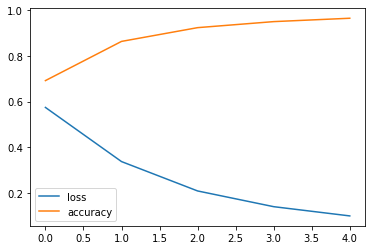

In [24]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['accuracy'], label= 'accuracy')
plt.legend()

In [25]:
predictions = model.predict(train_padded)
predictions = [1 if p > 0.5 else 0 for p in predictions]

In [57]:
print(train_phrases[10:20])

print(train_labels[10:20])
print(predictions[0])
 

['watch airport get swallowed sandstorm minute httptcorm50vcvjsh'
 'jacksonville family bands together memorial planned  httptcotilgurkv7z'
 'save date saturday august 15 2015 salisbury fire department open house 325 cypress st 10am to httptcooa6b0z2h6y'
 'real people true stories real pain  suffering displaced refugeesmatter syria httpstcooez7o9ab2c'
 'im fire httptcowatsmxytva'
 ' pls reduce cyclist deaths compulsory highway code test every vehicle uses road notrocketscience'
 'liked  video  httptcopdehd1tcpk minecraft skywars  blaze que usa hack e flechadas sinistras'
 'ancient mayan tablet hieroglyphics honors lowly king httptcowqikqx9e3w'
 'femas center disaster preparedness weeklong training chemical biological radioactive nuclear emergency response'
 'russian nuclearbiologicalchemical nbc brigade emergency response exercise southern md httptcoul5xdblmbk httptcovjhpvlnbaw']
[1 1 0 1 0 1 0 0 1 1]
0


In [65]:
def predict_catastrophe(text):
  # preprocessing the given text 
  text = text_cleaning(text[0])
  text = remove_punct(text)
  text = remove_stopwords(text)
  
  text_seq = tokenizer.texts_to_sequences(text)
  text_pad = pad_sequences(text_seq, maxlen=20)
  #print(text_pad)
  # predicting the class
  predicted_sentiment = model.predict(text_pad)
  print(predicted_sentiment[0].round())
 



In [67]:
predict_catastrophe(["the peace"])

[0.]
